In [1]:
%load_ext autoreload
%autoreload 2
import os
from encoding_information.gpu_utils import limit_gpu_memory_growth  
limit_gpu_memory_growth()
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"] = '2'

from signal_utils_1D import *
from plot_utils_1D import *

sampling_indices = (3, 4)

## show space bandwidth product

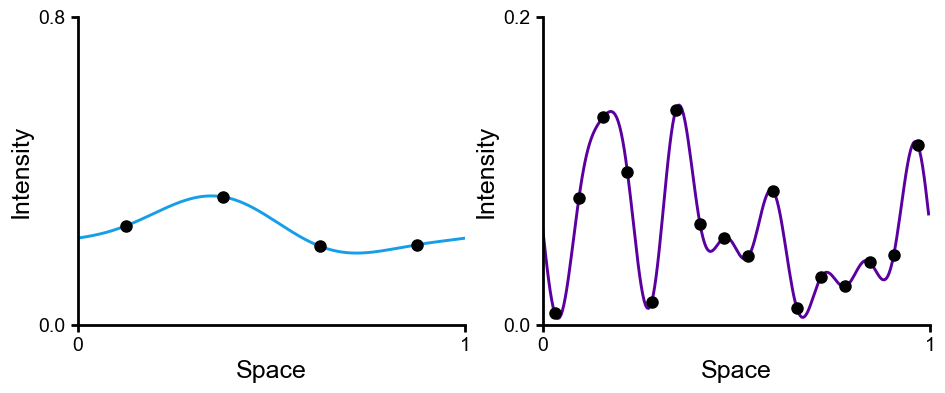

In [14]:

# plot a genrated signal and sample points
fig, ax = plt.subplots(1, 2, figsize=(11, 4))

num_nyquist_samples = 4
signal1 = bandlimited_nonnegative_signal(random_unnormalized_signal(num_nyquist_samples=num_nyquist_samples), num_nyquist_samples=num_nyquist_samples)
num_nyquist_samples = 16
signal2 = bandlimited_nonnegative_signal(random_unnormalized_signal(num_nyquist_samples=num_nyquist_samples), num_nyquist_samples=num_nyquist_samples)

plot_in_spatial_coordinates(ax[0], signal1, plot_lim=.8, show_samples=True, color_samples=False)
plot_in_spatial_coordinates(ax[1], signal2, plot_lim=.2, show_samples=True, color_samples=False, color=get_color_cycle()[1])


## Make a random bandlimited signal and show it in pixel coordinates and intensity coordinates 

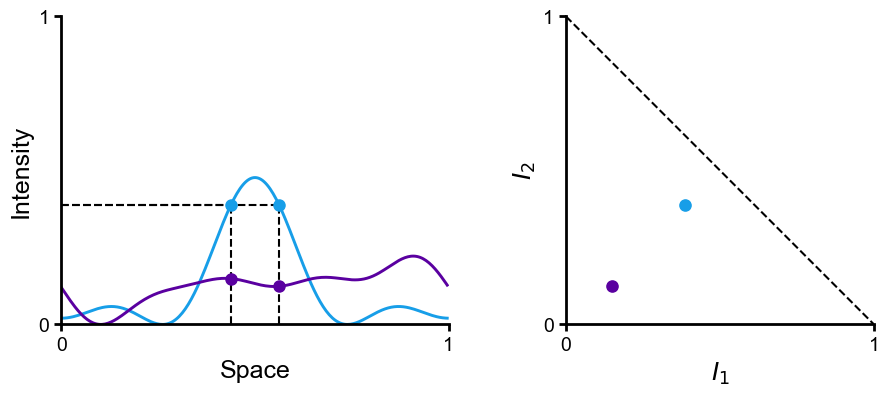

In [20]:
num_nyquist_samples = 8
# plot a genrated signal and sample points
fig, ax = plt.subplots(1, 2, figsize=(11, 4))

signal1 = generate_concentrated_signal(sampling_indices, num_nyquist_samples=num_nyquist_samples)
signal2 = bandlimited_nonnegative_signal(random_unnormalized_signal(num_nyquist_samples=num_nyquist_samples), num_nyquist_samples=num_nyquist_samples)

plot_in_spatial_coordinates(ax[0], signal1, sample_point_indices=sampling_indices,  color_samples=True,
                            vertical_line_indices=sampling_indices, horizontal_line_indices=sampling_indices, plot_lim=1, 
                            show_samples=True)
plot_in_intensity_coordinates(ax[1], signal1, markersize=65, plot_lim=1)

plot_in_spatial_coordinates(ax[0], signal2, plot_lim=1, 
                            sample_point_indices=sampling_indices, show_samples=True, color_samples=True,)
plot_in_intensity_coordinates(ax[1], signal2, markersize=65, plot_lim=1)


## Plot many randomly generate signals

nonnegative number of signals 49735


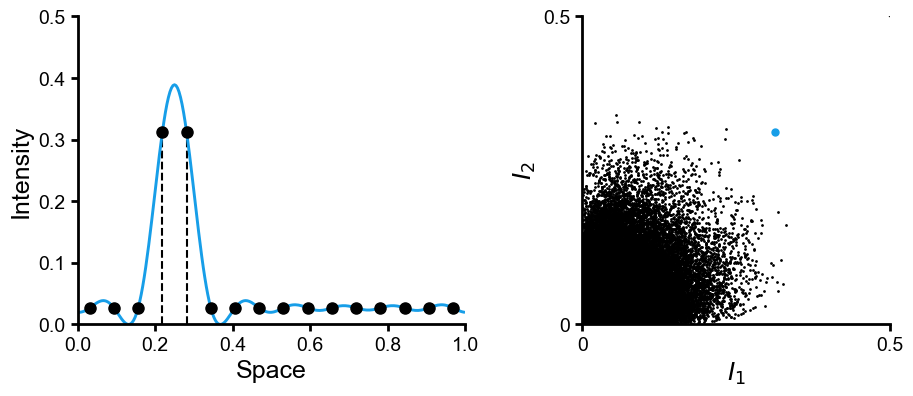

In [15]:
import jax

num_signals = 1000000
plot_lim = 0.5

# plot a genrated signal and sample points
fig, ax = plt.subplots(1, 2, figsize=(11, 4))
# plot a reference signal
concentrated_signal = generate_concentrated_signal(sampling_indices)
plot_in_spatial_coordinates(ax[0], concentrated_signal, vertical_line_indices=sampling_indices, plot_lim=plot_lim)

signals = jax.random.dirichlet(jax.random.PRNGKey(0), np.array(NUM_NYQUIST_SAMPLES * [.9]), shape=(num_signals,))
# signals = onp.random.dirichlet(NUM_NYQUIST_SAMPLES * [0.25], size=num_signals)
mask = check_if_nonnegative(signals)
rejected_signals = signals[np.logical_not(mask)]
signals = signals[mask]
print('nonnegative number of signals', signals.shape[0])

# plot_in_intensity_coordinates(ax[1], rejected_signals, markersize=1)
plot_in_intensity_coordinates(ax[1], signals, markersize=1, color='k', plot_lim=plot_lim)
plot_in_intensity_coordinates(ax[1], concentrated_signal,  markersize=25, plot_lim=plot_lim)


## Test optimization of a signal

In [ ]:

original_signal = bandlimited_nonnegative_signal(random_unnormalized_signal(num_nyquist_samples=num_nyquist_samples), num_nyquist_samples=num_nyquist_samples)
target_signal = onp.zeros_like(original_signal)
target_signal[sampling_indices[0]] = 0.5
target_signal[sampling_indices[1]] = 0.5
target_signal = np.array(target_signal)



object = sample_amplitude_object(type='delta')


initial_kernel = bandlimited_nonnegative_signal(random_unnormalized_signal(num_nyquist_samples=num_nyquist_samples), 
                                                num_nyquist_samples=num_nyquist_samples)
initial_signal = make_convolutional_encoder(initial_kernel, num_nyquist_samples=num_nyquist_samples) @ object
optimized_kernels, output_signals = optimize_towards_target_signals([target_signal], object,
                                                                    sampling_indices=sampling_indices,
                                                                   initial_kernel=initial_kernel, 
                                                                    verbose=True)
optimized_signal = output_signals[0]



In [34]:
target_signal

Array([0. , 0. , 0. , 0.5, 0.5, 0. , 0. , 0. ], dtype=float32)

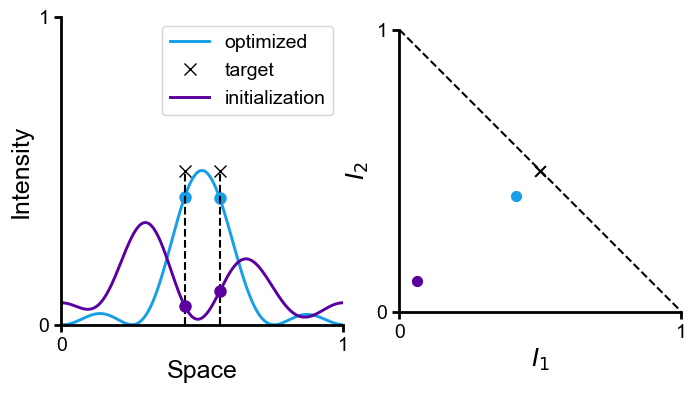

In [44]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4))


# plot the optimized signal
plot_in_spatial_coordinates(ax[0], optimized_signal,  label='optimized', sample_point_indices=sampling_indices, show_samples=True,
                            color_samples=True,)
                           
plot_in_intensity_coordinates(ax[1], optimized_signal, color=None, markersize=50, sample_point_indices=sampling_indices,)

# # plot the target signal
plot_in_spatial_coordinates(ax[0], target_signal, label='target', show_upsampled=False, sample_point_indices=sampling_indices,
                             vertical_line_indices=sampling_indices, color='k',
                             color_samples=True, marker='x', show_samples=True,)
plot_in_intensity_coordinates(ax[1], target_signal, marker='x', color='k', markersize=60,
                               sample_point_indices=sampling_indices)

# # plot the original signal
plot_in_spatial_coordinates(ax[0], original_signal, label='initialization', sample_point_indices=sampling_indices, color_samples=True,
                             vertical_line_indices=sampling_indices, show_samples=True,)
plot_in_intensity_coordinates(ax[1], original_signal, markersize=50, sample_point_indices=sampling_indices, )

ax[0].legend()

## Optimize signals to a grid of possibilities to figure out how they can be dispersed across intensity coordinates

100%|██████████| 130/130 [28:25<00:00, 13.12s/it]


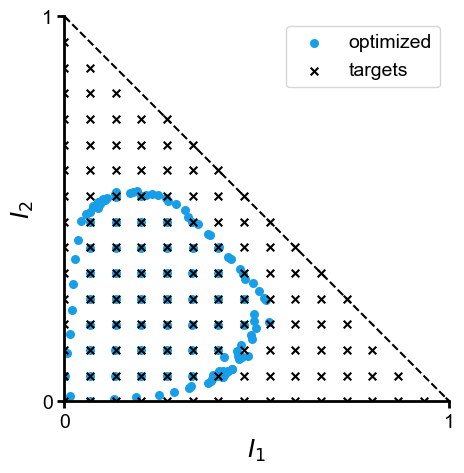

In [27]:
target_signals = make_intensity_coordinate_sampling_grid(sampling_indices, sample_n=16)
# original_signal = bandlimited_nonnegative_signal(random_unnormalized_signal())
# original_signal = generate_concentrated_signal(sampling_indices)

original_signal = np.ones_like(target_signals[0]) / target_signals[0].size
optimized_signals = []
for target_signal in tqdm(target_signals):
    optimized_params = run_optimzation(make_real_imag_loss_fn(target_signal, indices=sampling_indices), real_imag_bandlimit_energy_norm_prox_fn, 
                    np.concatenate(real_imag_params_from_signal(original_signal)), learning_rate=1e-3, verbose=False)
    optimized_signals.append(signal_from_real_imag_params(*param_vector_to_real_imag(optimized_params)))
optimized_signals = np.array(optimized_signals)


# make plots
fig, ax = plt.subplots(1, 1, figsize=(5,5))
# plot_in_intensity_coordinates(ax, original_signal, label='initialization')
plot_in_intensity_coordinates(ax, optimized_signals, label='optimized')
plot_in_intensity_coordinates(ax, target_signals, marker='x', label='targets', color='k')
ax.legend()
fig.savefig('/home/hpinkard_waller/figures/1d_signals/' + 'optmized_bandlimited_signals' + '.pdf', transparent=True)



### Add randomly sampled signals on top and show that they're not outside the range

nonnegative number of signals 30458


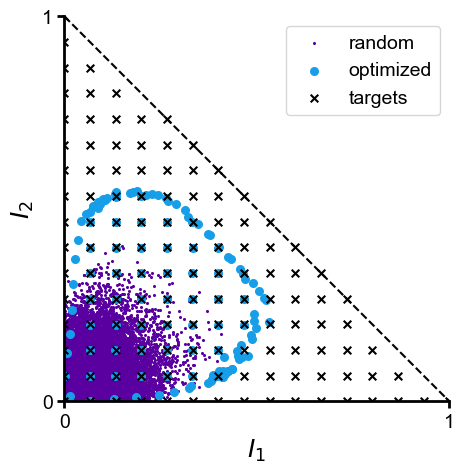

In [28]:
num_signals = 10000000
random_signals = jax.random.dirichlet(jax.random.PRNGKey(0), np.array(NUM_NYQUIST_SAMPLES * [.5]), shape=(num_signals,))
# signals = onp.random.dirichlet(NUM_NYQUIST_SAMPLES * [0.25], size=num_signals)
mask = check_if_nonnegative(random_signals)
rejected_signals = random_signals[np.logical_not(mask)]
random_signals = random_signals[mask]
print('nonnegative number of signals', random_signals.shape[0])


# make plots
fig, ax = plt.subplots(1, 1, figsize=(5,5))
# plot_in_intensity_coordinates(ax, original_signal, label='initialization')
plot_in_intensity_coordinates(ax, random_signals, label='random', color=get_color_cycle()[1], markersize=1.5)
plot_in_intensity_coordinates(ax, optimized_signals, label='optimized', color=get_color_cycle()[0])
plot_in_intensity_coordinates(ax, target_signals, marker='x', label='targets', color='k')


ax.legend()
fig.savefig('/home/hpinkard_waller/figures/1d_signals/' + 'optmized_bandlimited_signals_plus_random_samples' + '.pdf', transparent=True)
